In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### PCA implementation (Python Machine Learning, 3rd ed)


Eigenvalues 
%s [0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]


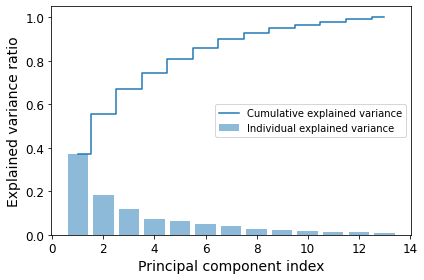

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


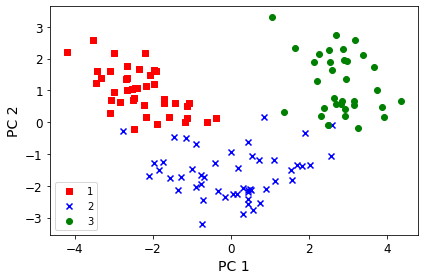

In [8]:
df = pd.read_csv('D:/Python Workout/wine.data', header=None)
# separate train and test data
from sklearn.model_selection import train_test_split
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# step: 1 - standardize the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# step:2 construct the covariant matrix
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
print('\nEigenvalues \n%s', eigen_vals)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

# step - 3: sort eigenvalues by decreasing order to rank eigenvectors
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# (eigenvalue, eigenvector) tuple
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# collect two eigenvectors based on two largest eigenvalues
# w = projection matrix which transforms data into lower-dimensional subspace
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],  # 13 by 2 dimensional
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

# transform x onto new PCA subspace
X_train_std[0].dot(w)

# transform entire dataset
X_train_pca = X_train_std.dot(w)

# visualize transformed wine dataset
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

#### PCA in scikit-learn

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

     # setup marker generator and color map
     markers = ('s', 'x', 'o', '^', 'v')
     colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
     cmap = ListedColormap(colors[:len(np.unique(y))])

     # plot the decision surface
     x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
     x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
     xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
          np.arange(x2_min, x2_max, resolution))
     Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
     Z = Z.reshape(xx1.shape)
     plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
     plt.xlim(xx1.min(), xx1.max())
     plt.ylim(xx2.min(), xx2.max())

     # plot examples by class
     for idx, cl in enumerate(np.unique(y)):
         plt.scatter(x=X[y == cl, 0],
         y=X[y == cl, 1],
         alpha=0.6,
         color=cmap(idx),
         edgecolor='black',
         marker=markers[idx],
         label=cl)

###### Training data reduced to two principal component axes (plot below)

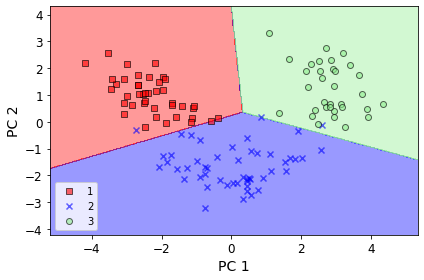

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr',
                       random_state=1,
                       solver='lbfgs')

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

# fitting the logistic regression model on the reduced dataset
lr.fit(X_train_pca, y_train)

#plot decision regions
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

###### plot logistic regression regions on transformed test dataset to see if it can separate the classes well 

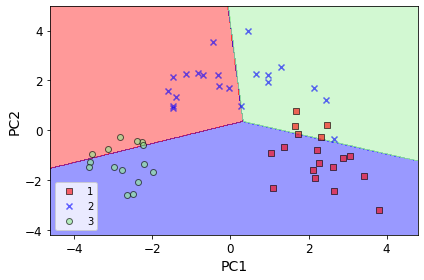

In [13]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

###### explained variance ratios of different principal components

In [14]:
pca = PCA(n_components=None) # None returns all principal components as sorted, instead of dim reduction
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])